<h1>Handwriting Letter GAN</h1>

<h3>Links</h3>
<ul>
    <li><a href=https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/>cGAN Code</a></li>
    <li><a href=https://keras.io/getting-started/functional-api-guide/>Keras Functional API</a></li>
</ul>

In [3]:
import numpy as np
from numpy.random import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from emnist import *
from skimage import data, io, transform
import matplotlib.pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

(112800, 28, 28) (112800,)
33
[0 0 0 ... 9 9 9]
(24000, 28, 28) (24000,)


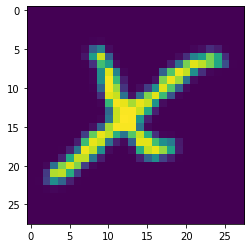

In [16]:
images, labels = extract_training_samples('balanced')
print(images.shape, labels.shape)
plt.imshow(images[908])
print(labels[908])
# ind = np.where(labels==8)
ind = []
for i in range(10):
  ind.extend(np.where(labels == i)[0])
print(labels[ind])
images, labels = images[ind], labels[ind]
print(images.shape, labels.shape)

In [0]:
def define_discriminator(input_shape=(28, 28, 1), n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(input_shape[0] * input_shape[1])(emb)
    re_label_h = Reshape((input_shape[0], input_shape[1], 1))(label_h)
    # image input
    image_in = Input(shape=input_shape)
    # combine inputs
    merge = Concatenate()([image_in, re_label_h])
    # convnet
    h1 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(h1)
    h2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(h2)
    # fully connected net
    fl = Flatten()(r2)
    dr = Dropout(0.4)(fl)
    # output
    out = Dense(1, activation='sigmoid')(dr)
    # define and compile model
    model = Model([image_in, label_in], out)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
def define_generator(latent_dim, n_classes=47):
    # label input and embedding
    label_in = Input(shape=(1, ))
    emb = Embedding(n_classes, 50)(label_in)
    label_h = Dense(7*7)(emb)
    re_label_h = Reshape((7, 7, 1))(label_h)
    # noisy image input
    noise_in = Input(shape=(latent_dim,))
    noise_h = Dense(128*7*7)(noise_in)
    noise_r = LeakyReLU(alpha=0.2)(noise_h)
    re_noise_r = Reshape((7, 7, 128))(noise_r)
    # combine inputs
    merge = Concatenate()([re_noise_r, re_label_h])
    # upsampling
    u1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    r1 = LeakyReLU(alpha=0.2)(u1)
    u2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(r1)
    r2 = LeakyReLU(alpha=0.2)(u2)
    # output
    out = Conv2D(1, (7, 7), activation='tanh', padding='same')(r2)
    # define model
    model = Model([noise_in, label_in], out)
    return model

In [0]:
def define_gan(gen, dis):
    # discriminator shouldn't be trainable
    dis.trainable = False
    # get generator inputs and outputs
    gen_noise, gen_label = gen.input
    gen_output = gen.output
    # feed to discriminator
    gan_output = dis([gen_output, gen_label])
    # define and compile GAN model
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=2e-4, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def prepare_inputs(images, labels):
    X = np.expand_dims(images, axis=-1)
    X = X.astype('float32')
    X = (X-127.5) / 127.5
    return [X, labels]
    
def generate_real_samples(images, labels, n_samples):
    rand_index = randint(0, images.shape[0], n_samples)
    X, labels = images[rand_index], labels[rand_index]
    y = np.ones((n_samples, 1))  # discriminator target label
    return [X, labels], y

def generate_latent_noise(latent_dim, n_samples, n_classes=47):
    xin = randn(latent_dim * n_samples)
    xin = xin.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)  #  generator class label
    return xin, labels

def generate_fake_samples(gen, latent_dim, n_samples):
    zin, lin = generate_latent_noise(latent_dim, n_samples)
    images = gen.predict([zin, lin])
    y = np.zeros((n_samples, 1))  # discriminator target label
    return [images, lin], y

In [0]:
def train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=128):
    batch_per_epoch = int(images.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # enumerate epochs
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # train discriminator on real images
            [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)
            d_loss1, _ = dis.train_on_batch([X_real, labels_real], y_real)
            # train discriminator on generated images
            [X_fake, labels_fake], y_fake = generate_fake_samples(gen, latent_dim, half_batch)
            d_loss2, _ = dis.train_on_batch([X_fake, labels_fake], y_fake)
            # prepare generator input
            [zin, label_in] = generate_latent_noise(latent_dim, batch_size)
            # invert labels for fake samples (prevent vanishing gradients)
            y_gan = np.ones((batch_size, 1))
            # update generator loss
            g_loss = gan_model.train_on_batch([zin, label_in], y_gan)
            # output losses
            print('Epoch {}, batch {}/{}:\tDiscriminator: real loss {}, fake loss {}\tGenerator: loss {}'
                  .format(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    # save the models
    gen.save('generator.h5')
    dis.save('discriminator.h5')
    gan_model.save('gan.h5')    

In [11]:
latent_dim = 100
images, labels = prepare_inputs(images, labels)
print(images.shape, labels.shape)
dis = define_discriminator()
gen = define_generator(latent_dim)
gan_model = define_gan(gen, dis)

(24000, 28, 28, 1) (24000,)


In [12]:
print("\nDiscriminator\n")
dis.summary()
print("\nGenerator\n")
gen.summary()
print("\nGAN\n")
gan_model.summary()


Discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        2350        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________

In [13]:
print(images.shape, labels.shape)
train_gan(gen, dis, gan_model, images, labels, latent_dim, n_epochs=100, batch_size=100)

Streaming output truncated to the last 5000 lines.
Epoch 80, batch 42/240:	Discriminator: real loss 0.10748331993818283, fake loss 0.17649637162685394	Generator: loss 9.630956649780273
Epoch 80, batch 43/240:	Discriminator: real loss 0.12926998734474182, fake loss 0.23684574663639069	Generator: loss 9.953667640686035
Epoch 80, batch 44/240:	Discriminator: real loss 0.12063834816217422, fake loss 0.104895681142807	Generator: loss 9.698787689208984
Epoch 80, batch 45/240:	Discriminator: real loss 0.13513506948947906, fake loss 0.07771632820367813	Generator: loss 8.472524642944336
Epoch 80, batch 46/240:	Discriminator: real loss 0.08828702569007874, fake loss 0.19883199036121368	Generator: loss 9.860851287841797
Epoch 80, batch 47/240:	Discriminator: real loss 0.12106513977050781, fake loss 0.31075426936149597	Generator: loss 9.002596855163574
Epoch 80, batch 48/240:	Discriminator: real loss 0.13068830966949463, fake loss 0.33483847975730896	Generator: loss 10.384827613830566
Epoch 80, ba

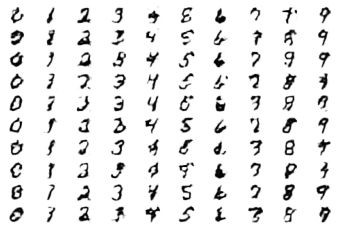

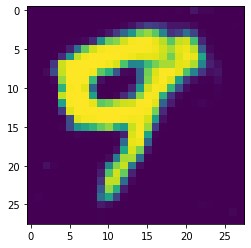

In [14]:
def show_plot(examples, n):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(examples[i,:,:,0], cmap='gray_r')
    plt.show()

model = load_model('generator.h5')
noise, _ = generate_latent_noise(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([noise, labels])
# scale from [-1, 1] to [0, 1]
X = (X + 1) / 2.0
show_plot(X, 10)
X[0].shape
for i in range(90):
    x = np.squeeze(X[i])
    plt.imshow(x)